# Sep 10, 2025: check if chains have converged

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.stats import gaussian_kde
from multiprocessing import Pool
import glob


import re
from joblib import Parallel, delayed
import math

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

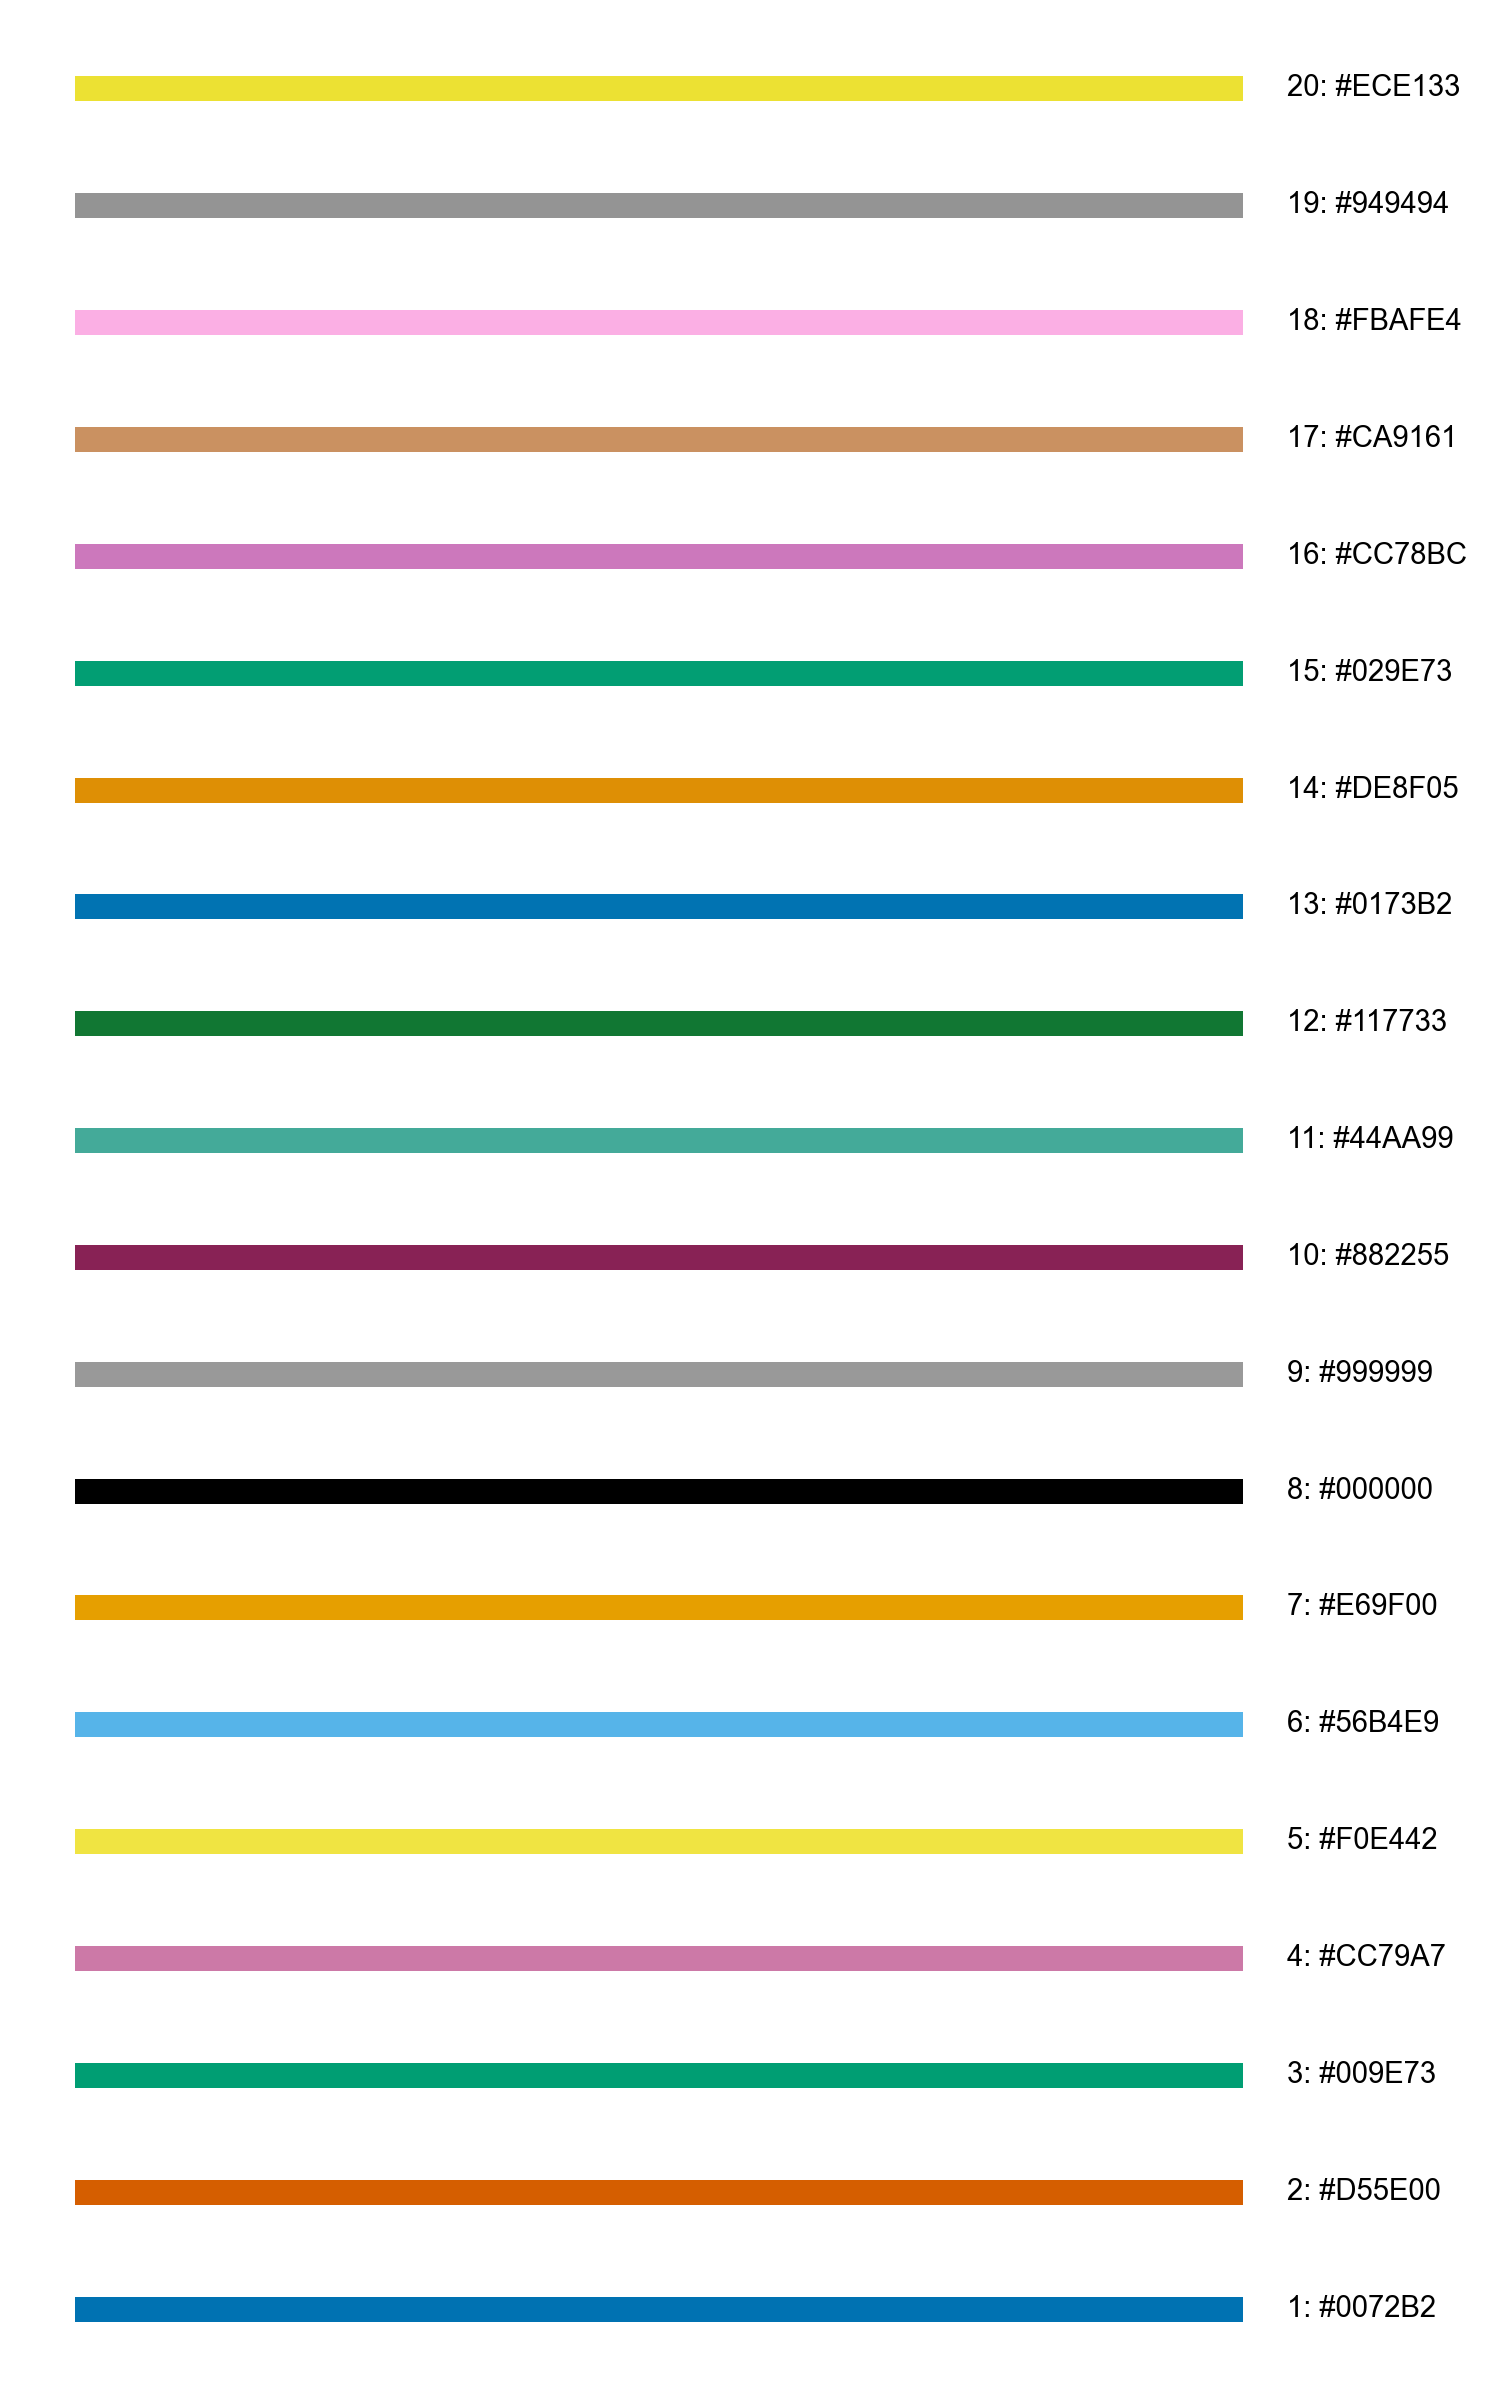

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.source = 'allen' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #334 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)

In [8]:
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics_insets'
os.system(f'mkdir -p {DIAG_path}')

GRAPH_boot_path = f'{ROI_RESULTS_path}-boot/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_boot_path = f'{ROI_RESULTS_path}-boot/model-fits'
os.system(f'mkdir -p {SBM_path}')

0

In [9]:
SBM_path

'/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/model-fits'

In [10]:
args.dc, args.sbm = False, 'o'
args.force_niter = 3000 if args.sbm in ['o'] else 100000 #40000 
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.2 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 75).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-o'

In [11]:
def collect_sbm_files(args, sbm_files):
    sbms_df = []
    for file in tqdm(sbm_files):
        try:
            with open(file, 'rb') as f:
                [bs, Bs, Bes, dls] = pickle.load(f)
            
            fs = file.split('/')
            sub = f'grp' #'-'.join([s for s in fs if 'sub-' in s][0].split('-')[1:])
            sbm = [s for s in fs if 'sbm-' in s][0]
            B = [s for s in fs if 'B-' in s][0].split('-')[-1]

            Bes = Bes[0] if args.sbm in ['h'] else Bes
            
            row = pd.DataFrame(dict(
                sub=[sub],
                sbm=[sbm],
                chain=[B],
                Bes=[dls], #dls, Bes
            ))
            sbms_df += [row]
        # break
        except:
            pass
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/B-*/desc-partitions.pkl', recursive=True))
sbms_df = collect_sbm_files(args, sbm_files)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 23.60it/s]


In [12]:
def collect_sbm_boot_files(args, sbm_boot_files):
    sbms_df = []
    for file in tqdm(sbm_boot_files):
        try:
            if not args.sbm == 'o':
                with open(file, 'rb') as f:
                    [Bes, dls] = pickle.load(f)
            else:
                with open(file, 'rb') as f:
                    [_, _, Bes, dls] = pickle.load(f)
            
            match = re.search(r'boot-(\d+)/(sbm-[^/]+)/B-(\d+)', file)
            if match:
                boot, sbm, B = match.groups()
            
            Bes = Bes[0] if args.sbm in ['h'] else Bes
            
            row = pd.DataFrame(dict(
                sub=[f'boot-{boot}'],
                sbm=[sbm],
                chain=[B],
                Bes=[dls], # dls, Bes
            ))
            sbms_df += [row]
        except:
            pass
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

if not args.sbm == 'o':
    sbm_boot_files = sorted(glob.glob(f'{SBM_boot_path}/*/{SBM}/B-*/desc-Bes-dls.pkl', recursive=True))
else:
    sbm_boot_files = sorted(glob.glob(f'{SBM_boot_path}/*/{SBM}/B-*/desc-partitions.pkl', recursive=True))
sbms_boot_df = collect_sbm_boot_files(args, sbm_boot_files)

100%|██████████| 199/199 [00:10<00:00, 18.76it/s]


In [13]:
sbms_df = pd.concat([sbms_df, sbms_boot_df])
replacement_dict = {val: f'{i+1}' for i, val in enumerate(sbms_df['chain'].unique())}
sbms_df['chain'] = sbms_df['chain'].replace(replacement_dict)
len(sbms_df.iloc[9]['Bes']) + 1

3001

In [14]:
sbms_df.head(n=10)

,sub,sbm,chain,Bes
0,grp,sbm-nd-o,1,"[6107.404050596771, 6105.812322697213, 6237.00..."
1,grp,sbm-nd-o,2,"[6149.242637657914, 6068.680724873793, 6047.76..."
2,grp,sbm-nd-o,3,"[6243.6579906355655, 6099.528922705978, 6175.5..."
3,grp,sbm-nd-o,4,"[6100.092560804026, 6214.393399884042, 6032.78..."
4,grp,sbm-nd-o,5,"[6060.141501248567, 6213.851561425378, 6045.79..."
0,boot-00,sbm-nd-o,1,"[6141.065328335357, 6182.015680147113, 6882.55..."
1,boot-00,sbm-nd-o,2,"[6122.473865298851, 6161.575629173261, 6248.34..."
2,boot-00,sbm-nd-o,3,"[6248.717831640322, 6214.094353871102, 6170.85..."
3,boot-00,sbm-nd-o,4,"[7087.231290947269, 6210.51883298292, 6220.457..."
4,boot-00,sbm-nd-o,5,"[6138.323626870952, 6190.566559770826, 6287.74..."


In [15]:
def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    
    ksds_df = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        ts = np.arange(10, args.force_niter, args.delta)
        for t in ts:
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': ts,
            'D': Ds,
        })
        ksds_df.append(df)
    ksds_df = pd.concat(ksds_df).reset_index(drop=True)
    return ksds_df

def plot_KSD_inset(inset_ax, args, chains_df, ksds_df):
    """
    Plot KSD convergence curves into a given inset axis.
    Returns True if model is converged by midpoint criterion.
    """
    from itertools import combinations
    import numpy as np

    chain_idxs = chains_df.index.to_list()
    Ds = []

    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksds_df[
            (ksds_df['ch1'] == idx1) &
            (ksds_df['ch2'] == idx2)
        ][['t', 'D']].to_numpy()

        Ds.append(t_D[:, 1])
        inset_ax.plot(
            t_D[:, 0],
            t_D[:, 1],
            color=CUD_COLORS[0],
            alpha=0.5,
            linewidth=0.75,
        )

    Ds = np.stack(Ds, axis=-1)
    T = Ds.shape[0]
    converged = np.all(Ds[T//2:, :] < args.epsilon)
    
    t = t_D[:, 0]
    inset_ax.plot(t, np.median(Ds, axis=-1), color=CUD_COLORS[1], linewidth=1.0)
    inset_ax.plot(t, args.epsilon * np.ones_like(t), color="#999999", linestyle="--", linewidth=0.8)
    inset_ax.axvline(x=args.num_draws, color="#CA9161", linestyle="--", linewidth=0.8)

    # Style
    # title = '' if converged else 'ill-suited'
    # inset_ax.set_title(f'{title}', fontsize=6)
    inset_ax.set_ylabel("KSD", fontsize=6, labelpad=-6)
    inset_ax.set_xlabel("MCMC steps", fontsize=6, labelpad=-6)
    xmin, xmax = inset_ax.get_xlim()
    xticks = np.linspace(xmin, xmax, 5)
    inset_ax.set_xticks([np.ceil(xt) for xt in xticks], labels=['0', '', '', '', '10'])
    inset_ax.set_yticks([0, 0.5, 1], [0, '', 1])
    inset_ax.tick_params(labelsize=6, width=0.5, length=2)
    for spine in inset_ax.spines.values():
        spine.set_linewidth(0.5)
    inset_ax.grid(alpha=0.3)
    
    return converged, np.mean(Ds, axis=-1)

In [16]:
def plot_density_overlap(ax, args, chains_df, label='None', legend=False):
    df = chains_df.explode('Bes_conv')
    
    sns.kdeplot(
        data=df, ax=ax,
        x='Bes_conv',
        hue='chain',
        palette=CUD_COLORS,
        fill=True,
        alpha=0.1,
        legend=False,
    )

    ax.set_title(f'{label}', fontsize=7, pad=2)
    ax.set_xlabel('description length', fontsize=7,)# labelpad=2)
    ax.set_ylabel('density', fontsize=7)
    ax.set_yticklabels([])  # clean y-axis for panel plots
    ax.tick_params(axis='y', which='major', length=2.5, width=0.5)
    ax.grid(alpha=0.15, linewidth=0.3)

    # Rounded xticks
    xmin, xmax = ax.get_xlim()
    xticks = np.linspace(xmin, xmax, 5)
    ax.set_xticks(np.round(xticks, 1))
    ax.tick_params(axis='x', which='major', length=2.5, width=0.5)

    return None

In [17]:
def create_diagnostics_plots(args, sbms_df):
    ncols = 1
    nrows = 2 #len(sbms_df['sub'].unique())

    a = 20 / 9 # 3.0
    b = a * 4 / 7 # 2.3

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(a*ncols, b*nrows), # inches
        sharex=False, sharey=False
    )
    fig.tight_layout(h_pad=0, w_pad=0)

    mean_ksds = []

    for idx, (sub, group) in tqdm(enumerate(sbms_df.groupby(by=['sub']))):
        sub = sub[0]
        group = group.reset_index(drop=True)
        group['Bes_conv'] = group['Bes'].apply(lambda x: x[-args.num_draws:])
        display(group)

        ax = axs[idx, 1] if ncols > 1 else axs[idx]
        
        legend = False # idx < 1
        plot_density_overlap(ax, args, group, label=f'sub-{sub}', legend=legend)

        ksds_df = KSD(args, group)
        iax = inset_axes(ax, width='45%', height='45%', loc='upper right', borderpad=0.5)
        converged, mean_ksd = plot_KSD_inset(iax, args, group, ksds_df)
        mean_ksds.append(mean_ksd)
        display(converged)

    # break
    # ref_pos = axs[0].get_position()
    ref_pos = ax.get_position()
    return fig, np.stack(mean_ksds, axis=0), ref_pos

In [18]:
def _prep_group(args, sub, group):
    group = group.reset_index(drop=True)
    group['Bes_conv'] = group['Bes'].apply(lambda x: x[-args.num_draws:])
    ksds_df = KSD(args, group)
    return sub, group, ksds_df

In [19]:
groups = [ (s, g) for s, g in sbms_df.groupby(by=['sub']) ]
results = Parallel(n_jobs=5, backend='loky')(
    delayed(_prep_group)(args, sub[0], group)
    for sub, group in groups
)
# results keeps original groupby order

In [20]:
def create_diagnostics_plots(args, results, sbms_df):
    ncols = 5
    subs = list(sbms_df['sub'].unique())
    nsubs = len(subs)
    nrows = math.ceil(nsubs / ncols)

    a = 20 / 9
    b = a * 4 / 7
    
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(a*ncols, b*nrows),
        sharex=False, sharey=False
    )
    axs = np.atleast_2d(axs)
    fig.tight_layout(h_pad=2.5, w_pad=0)
    
    mean_ksds = []
    for idx, (sub, group, ksds_df) in enumerate(results):
        r, c = divmod(idx, ncols)
        ax = axs[r, c]
        
        legend = False
        plot_density_overlap(ax, args, group, label=f'sub-{sub}', legend=legend)
        iax = inset_axes(ax, width='45%', height='45%', loc='upper right', borderpad=0.5)
        converged, mean_ksd = plot_KSD_inset(iax, args, group, ksds_df)
        mean_ksds.append(mean_ksd)
        
    for k in range(len(results), nrows*ncols):
        r, c = divmod(k, ncols)
        axs[r, c].axis('off')
    
    ref_pos = axs[0, 0].get_position() if nsubs > 0 else None
    return fig, np.stack(mean_ksds, axis=0), ref_pos

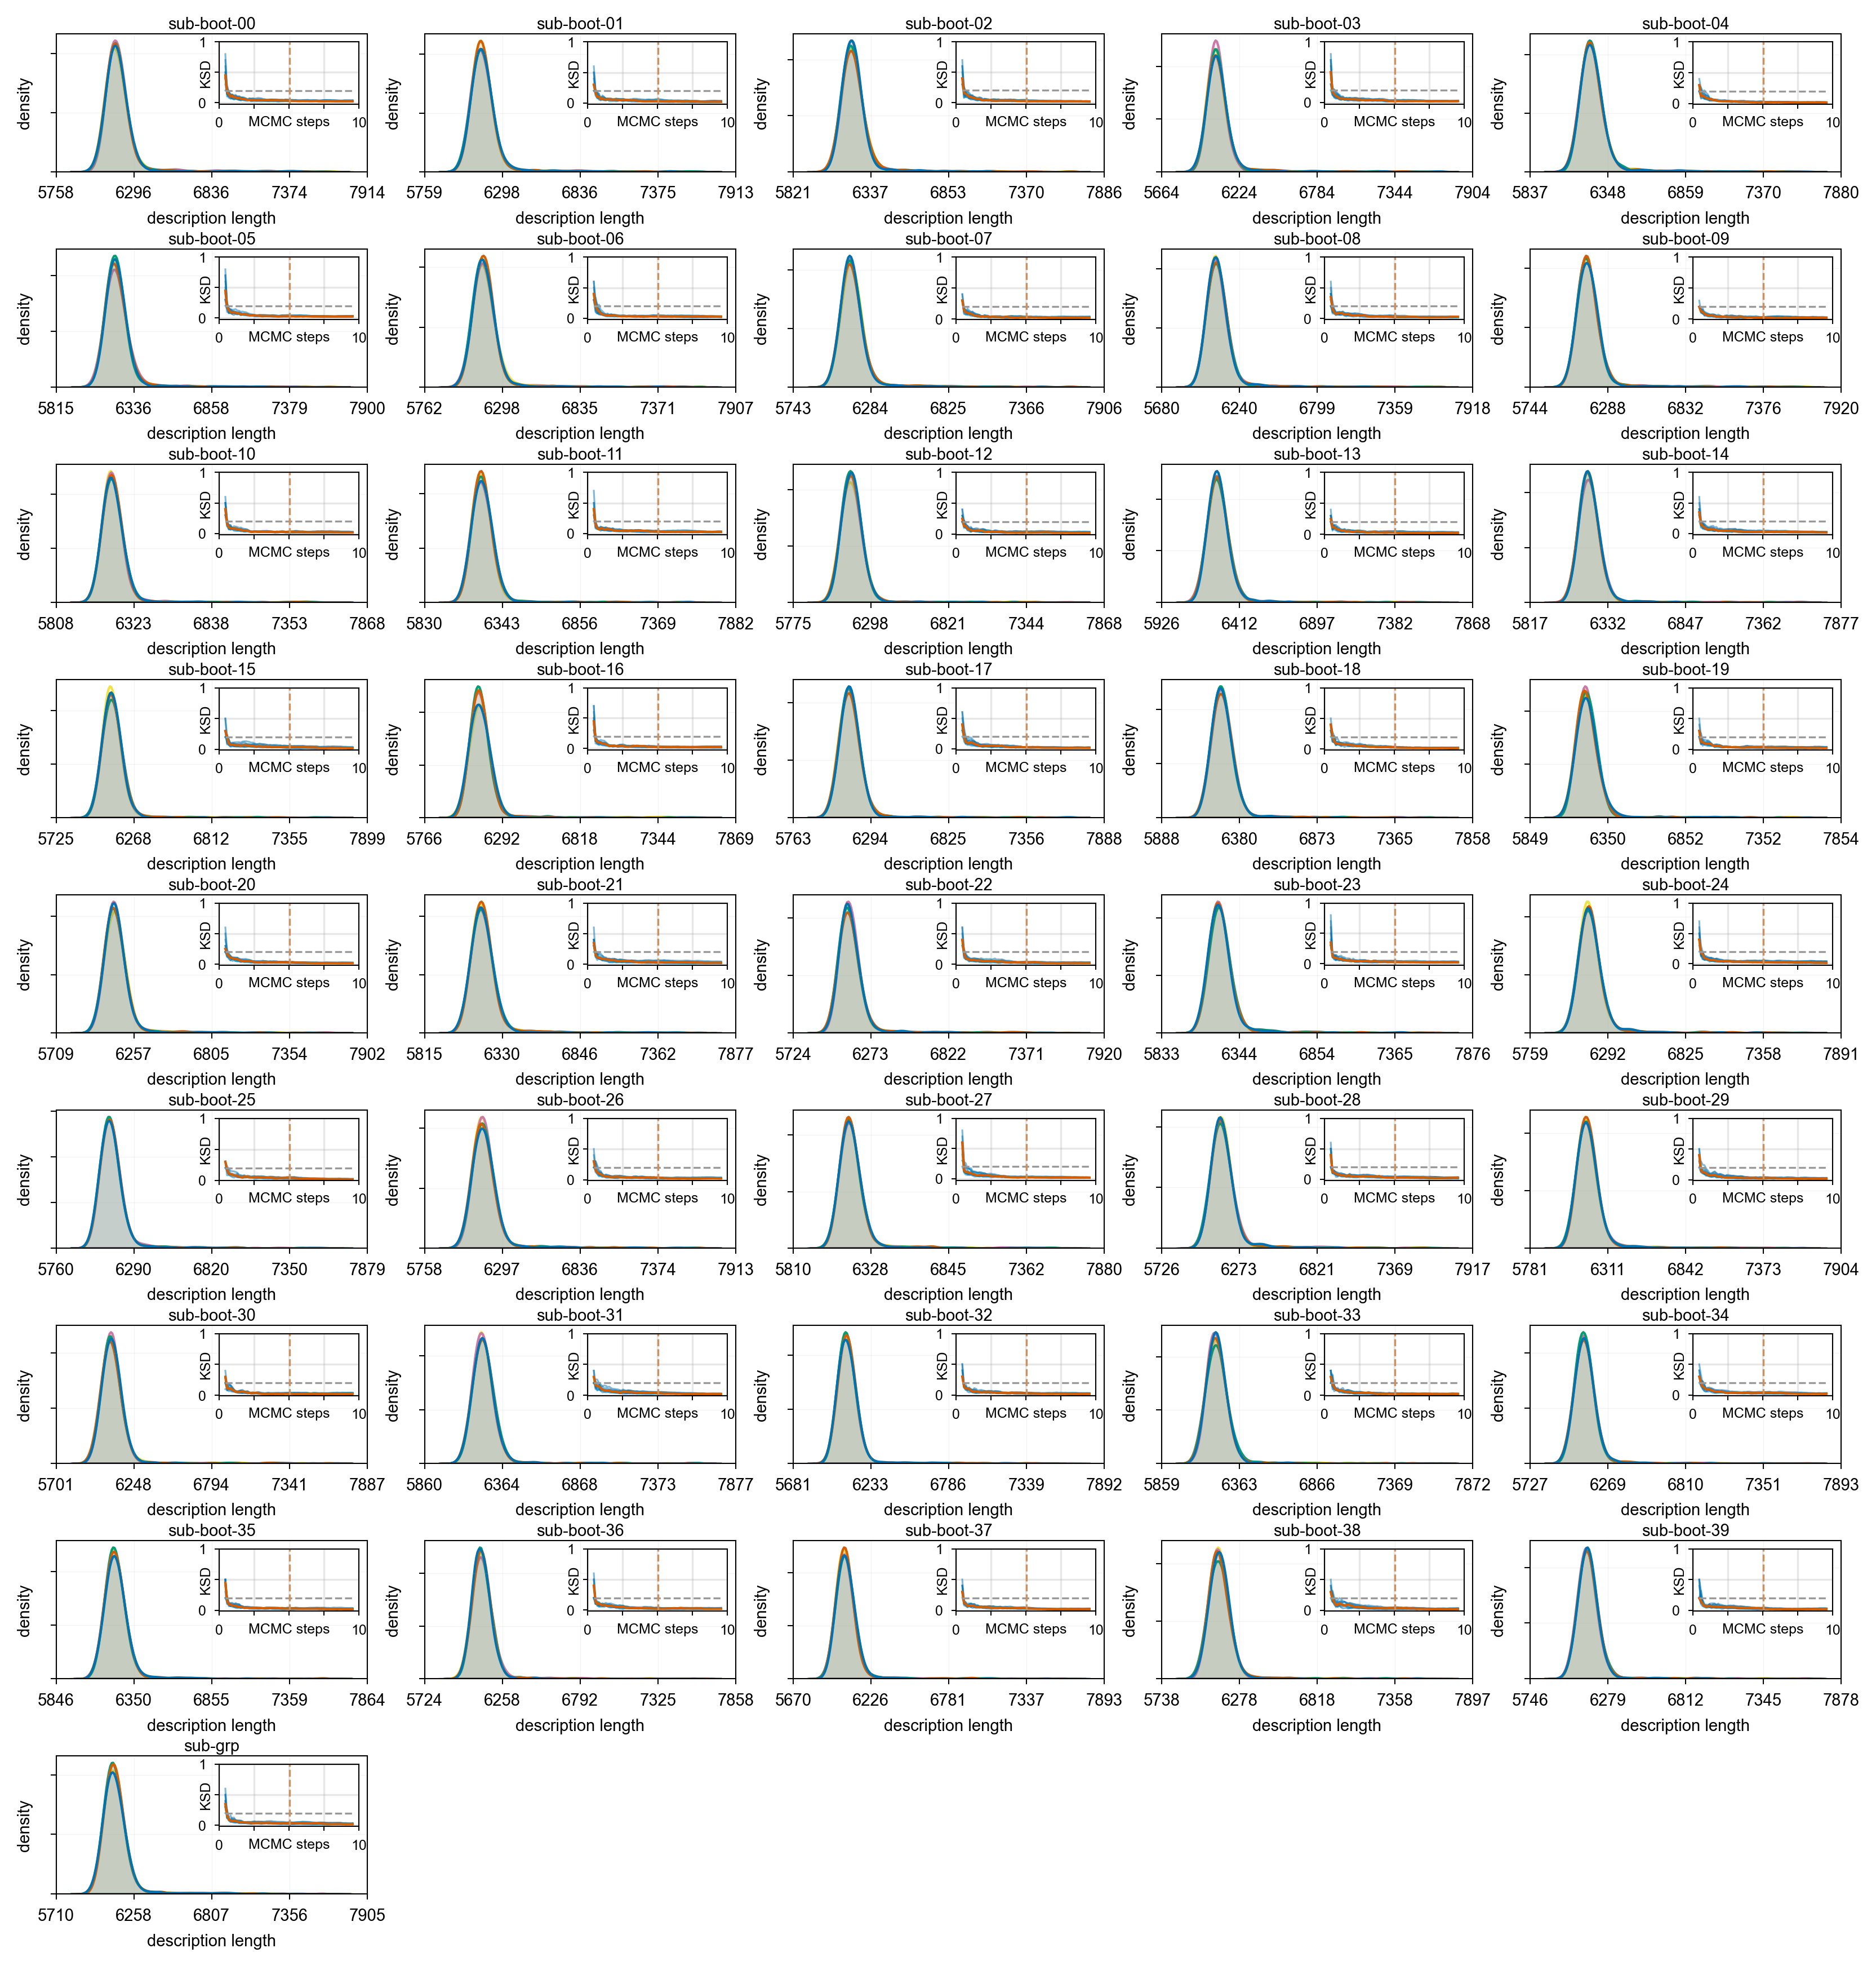

In [ ]:
# figfile = f'{DIAG_path}/{SBM}_desc-diagnostics.png'
# if os.path.exists(figfile):
#     display(Image(figfile))
# else:
#     fig, mean_ksds, ref_pos = create_diagnostics_plots(args, results, sbms_df)

In [22]:
mean_ksds.shape

(41, 75)

In [23]:
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.png', bbox_inches='tight', transparent=True)
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.svg', bbox_inches='tight', transparent=True)

In [24]:
def bootstrap_ci(data, ci=95):
    """
    data: array of shape (n_boots, n_steps)
    Returns lower and upper CI bounds for the median across animals, per timepoint.
    """
    n_boots, n_steps = data.shape
    ci_bounds = np.empty((2, n_steps))

    for t in range(n_steps):
        lower = np.percentile(data[:, t], (100 - ci) / 2)
        upper = np.percentile(data[:, t], 100 - (100 - ci) / 2)
        ci_bounds[:, t] = [lower, upper]

    return ci_bounds

def plot_group_level_summary(args, mean_ksds):
    ncols = 1
    nrows = 1

    a = 20 / 9  # ~2.22
    b = a * 3.5 / 7  # ~1.27

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(a * ncols, b * nrows),
        sharex=False, sharey=False
    )

    ax = axs
    t = np.arange(mean_ksds.shape[0])
    mid_point = t[t.shape[0]//2]

    
    # Compute 95% CI across the sample 
    # sample is the last column of mean_ksds
    grp_curve = mean_ksds[:, -1]
    ci_bounds = bootstrap_ci(mean_ksds[:, :-1].T, ci=95)
    
    # plot the curves over bootstrap resamples
    ax.plot(t, mean_ksds[:, 0], color=CUD_COLORS[0], linewidth=0.75, alpha=0.5, label='resamples')
    ax.plot(t, mean_ksds[:, 1:], color=CUD_COLORS[0], linewidth=0.75, alpha=0.5)
    
    # Plot median with 95%CI band
    # ax.plot(t, grp_curve, color=CUD_COLORS[1], linewidth=1.0, label='sample')
    ax.fill_between(
        t,
        ci_bounds[0],
        ci_bounds[1],
        color=CUD_COLORS[1],
        alpha=0.3,
        label='95% CI'
    )

    # Convergence quality zones
    ax.plot(t, 0.2 * np.ones_like(t), color='#009E73', linewidth=0.8, linestyle='--', label='acceptable threshold (0.2)')
    ax.axvline(x=mid_point, color="#CA9161", linestyle="--", linewidth=0.8, alpha=1.0, label='chain mid-point')

    # Axis settings
    ax.set_title(f'{SBM}', fontsize=7, pad=2)
    ax.set_ylabel('KSD', fontsize=7)
    ax.set_xlabel('MCMC steps', fontsize=7)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels(['0', '0.5', '1'])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(np.array([0, 0.25, 0.5, 0.75, 1.0])*len(t))
    ax.set_xticklabels(['0', '25', '50', '75', '100'])
    ax.tick_params(axis='both', which='major', labelsize=7, length=2.5, width=0.5)
    ax.grid(alpha=0.15, linewidth=0.3)

    # Optional legend
    ax.legend(fontsize=7, frameon=True, loc='upper right')

    # fig.tight_layout()

    return fig


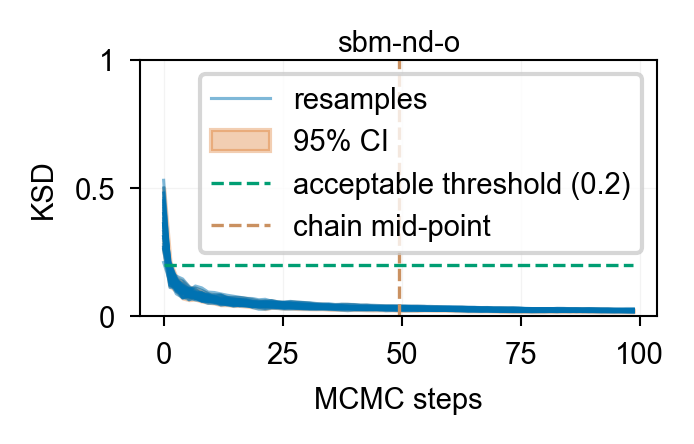

In [25]:
fig_group = plot_group_level_summary(args, mean_ksds.T)

In [26]:
fig_group.savefig(f'{DIAG_path}/{SBM}_desc-group_summary.png', bbox_inches='tight', transparent=True)
fig_group.savefig(f'{DIAG_path}/{SBM}_desc-group_summary.svg', bbox_inches='tight', transparent=True)